In [24]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import mse as sm_mse, rmse as sm_rmse, meanabs as sm_mae
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, TFT, PatchTST, TCN, DLinear, RNN, LSTM, Autoformer, BiTCN, DeepAR, DeepNPTS, DilatedRNN, FEDformer, GRU, HINT, Informer, iTransformer, KAN, MLP, MLPMultivariate, NBEATSx, NLinear, RMoK, SOFTS, StemGNN, TiDE, TimeMixer, TimeLLM, TimesNet, TSMixer, TSMixerx, VanillaTransformer
from neuralforecast.losses.pytorch import MQLoss, MAE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from neuralforecast.utils import AirPassengersDF
import time
import torch
torch.set_float32_matmul_precision('high')  # or 'medium' for more precision
import plotly.express as px
import plotly.graph_objects as go
from sklearn.utils import check_random_state
import logging
logging.basicConfig(level=logging.INFO)
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
random_state = check_random_state(seed)

In [25]:
# Re-load the dataset (user needs to re-upload the file)
df = pd.read_csv(f"../data/Top_12_German_Companies_Financial_Data.csv") # Load the dataset

# Filter dataset for SAP SE only
sap_df = df[df["Company"] == "SAP SE"].copy()

# Convert Period column to datetime format
sap_df["Period"] = pd.to_datetime(sap_df["Period"], format="%m/%d/%Y")

# Sort data by Period for proper time-series analysis
sap_df = sap_df.sort_values(by="Period")

# Convert revenue to numeric
sap_df["Revenue"] = pd.to_numeric(sap_df["Revenue"], errors="coerce")
sap_df= sap_df[["Revenue", 'Period']]

In [26]:
# Convert 'Year' column to datetime if it's not already
sap_df['ds'] = pd.to_datetime(sap_df['Period'], format='%Y')
sap_df['unique_id'] = "all"
sap_df = sap_df.rename(columns={"Revenue": "y"}) 
sap_df = sap_df[["unique_id", "ds", "y"]] 

<Axes: title={'center': 'SAP SE Revenue Over Time'}>

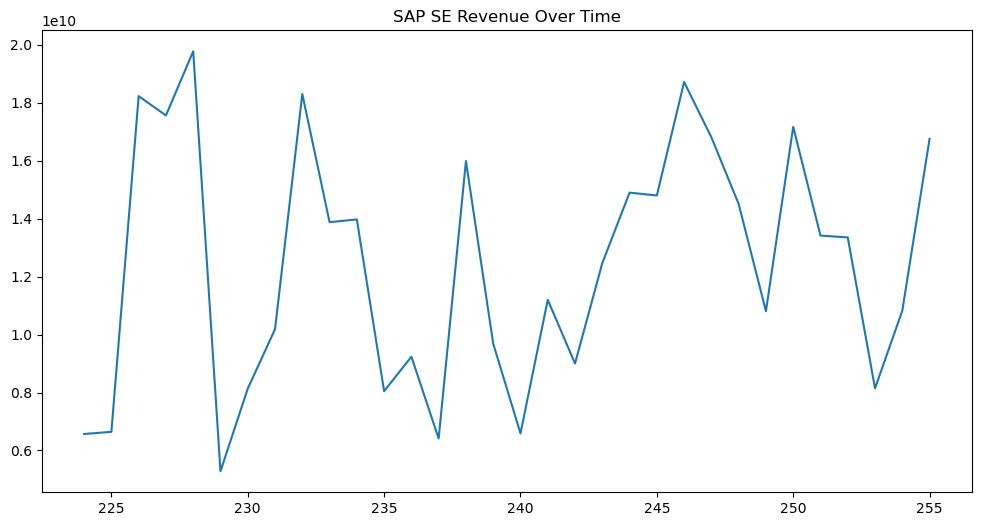

In [27]:
sap_df["y"].plot(figsize=(12, 6), title="SAP SE Revenue Over Time")

In [28]:
sap_df.head()

,unique_id,ds,y
224,all,2017-03-31,6568715630
225,all,2017-06-30,6644029236
226,all,2017-09-30,18227487487
227,all,2017-12-31,17560385805
228,all,2018-03-31,19774628627


In [29]:
# Train-test split
test_size = int(len(sap_df) * 0.2)
train = sap_df[:len(sap_df) - test_size]
val = sap_df[len(sap_df) - test_size:]

In [30]:
scaler = StandardScaler()
train["y"] = scaler.fit_transform(train["y"].values.reshape(-1,1)) 
val["y"] = scaler.fit_transform(val["y"].values.reshape(-1,1)) 

/tmp/ipykernel_8823/3068135353.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_8823/3068135353.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
# Confirm split integrity
print(f"Data split: Total: {len(sap_df)}, Train: {len(train)}, Test: {len(val)}")
print("Training set date range:", train['ds'].min(), "to", train['ds'].max())
print("Testing set date range:", val['ds'].min(), "to", val['ds'].max())
train.set_index('ds', inplace=False)
val.set_index('ds', inplace=False)

Data split: Total: 32, Train: 26, Test: 6
Training set date range: 2017-03-31 00:00:00 to 2023-06-30 00:00:00
Testing set date range: 2023-09-30 00:00:00 to 2024-12-31 00:00:00


,unique_id,y
ds,,
2023-09-30,all,1.234502
2023-12-31,all,0.043992
2024-03-31,all,0.023980
2024-06-30,all,-1.628099
2024-09-30,all,-0.777871
2024-12-31,all,1.103497


In [32]:
sap_df.head()

,unique_id,ds,y
224,all,2017-03-31,6568715630
225,all,2017-06-30,6644029236
226,all,2017-09-30,18227487487
227,all,2017-12-31,17560385805
228,all,2018-03-31,19774628627


In [33]:

# Custom SMAPE function
def smape_loss(y_true, y_pred):
    y_true = y_true.values
    y_pred = y_pred.values
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Function to evaluate models (Now includes MASE from statsmodels)
def evaluate_model(y_true, y_pred, y_train, model_name, start_time):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = smape_loss(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Compute MASE using statsmodels mean absolute error
    naive_forecast_errors = np.abs(y_train.diff()).dropna()
    mae_naive = sm_mae(naive_forecast_errors, np.zeros_like(naive_forecast_errors))  # Naïve MAE
    mase = sm_mae(y_true, y_pred) / mae_naive if mae_naive != 0 else np.nan  # Avoid division by zero

    runtime = time.time() - start_time

    return {
        "Model": model_name,
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "SMAPE": smape,
        "MASE": mase,  # Now using established library
        "R2 Score": r2,
        "Time (s)": runtime
    }


In [34]:
results = []
input_size=12
models = [
    # ✅ Best models for univariate forecasting
    #NBEATS(h=12, input_size=input_size, loss=MQLoss(), alias='NBEATS_12'),  # Strong for univariate
    #NHITS(h=12, input_size=input_size, loss=MQLoss(), alias='NHITS_12'),  # Successor to NBEATS, efficient
    DLinear(h=12, input_size=input_size, loss=MQLoss(), alias='DLinear_12'),  # Simple & effective for univariate
    #RNN(h=12, input_size=input_size, loss=MAE(), alias='RNN_12'),  # Baseline RNN model
    #LSTM(h=12, input_size=input_size, loss=MAE(), alias='LSTM_12'),  # More expressive than RNN
    #TCN(h=12, input_size=input_size, loss=MQLoss(), alias='TCN_12'),  # Captures long-range dependencies
    #BiTCN(h=12, input_size=input_size, loss=MQLoss(), alias='BiTCN_12'),  # Bidirectional TCN for better sequence modeling

    # 🔶 Can be used for univariate, but primarily optimized for multivariate
    #TFT(h=12, input_size=input_size, loss=MQLoss(), alias='TFT_12'),  # Designed for multivariate but works for univariate
    #PatchTST(h=12, input_size=input_size, loss=MQLoss(), alias='PatchTST_12'),  # Transformer-based, supports univariate
    #Autoformer(h=12, input_size=input_size, loss=MQLoss(), alias='Autoformer_12'),  # Autocorrelation-based Transformer
]


Global seed set to 1


In [35]:
# def get_models(horizon=12, input_size=12, quantiles=[0.1, 0.5, 0.9], include_tcn=False, include_bitcn=False):
#     """
#     Returns a list of NeuralForecast models for univariate forecasting.

#     Parameters:
#     - horizon (int): Forecast horizon (number of future time steps to predict).
#     - input_size (int): Number of past time steps used as input.
#     - quantiles (list): Quantiles for probabilistic forecasting.
#     - include_tcn (bool): Whether to include Temporal Convolutional Network (TCN).
#     - include_bitcn (bool): Whether to include Bidirectional TCN.

#     Returns:
#     - List of initialized models.
#     """

#     # Define the models dynamically
#     models = [
#         NBEATS(h=horizon, input_size=input_size, loss=MQLoss(quantiles=quantiles), alias='NBEATS'),
#         NHITS(h=horizon, input_size=input_size, loss=MQLoss(quantiles=quantiles), alias='NHITS'),
#         DLinear(h=horizon, input_size=input_size, loss=MQLoss(quantiles=quantiles), alias='DLinear'),
#     ]

#     # Conditionally add models based on user selection
#     if include_tcn:
#         models.append(TCN(h=horizon, input_size=input_size, loss=MQLoss(quantiles=quantiles), alias='TCN'))
#     if include_bitcn:
#         models.append(BiTCN(h=horizon, input_size=input_size, loss=MQLoss(quantiles=quantiles), alias='BiTCN'))

#     return models

# # Example Usage: Get models with TCN but not BiTCN
# models = get_models(include_tcn=True, include_bitcn=False)

In [36]:
# Initialize NeuralForecast
results = []
start_time = time.time()
nf = NeuralForecast(models=models, freq='Q')
nf.fit(train)
forecast_df = nf.predict()

# Evaluate models
for model_name in forecast_df.columns:
    if model_name == "ds" or model_name == "unique_id":
        continue
    y_pred = forecast_df[model_name]#.astype(float)  # Ensure numeric type
    #print(y_pred)
    #results.append(evaluate_model(val["y"].astype(float), y_pred, f"{model_name} (NeuralForecast)", start_time))
    y_pred = y_pred[:val["y"].shape[0]]
    results.append(evaluate_model(val["y"].astype(float), y_pred, train["y"], f"{model_name} (NeuralForecast)", start_time))



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MQLoss        | 5     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | decomp        | SeriesDecomp  | 0     
4 | linear_trend  | Linear        | 780   
5 | linear_season | Linear        | 780   
------------------------------------------------
1.6 K     Trainable params
5         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
/opt/conda/envs/ai_env/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.

/opt/conda/envs/ai_env/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [37]:
# Convert results to DataFrame and sort by MAPE
df_results = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)

print(df_results)

                                Model       MSE       MAE       MAPE  \
4   DLinear_12-hi-90 (NeuralForecast)  0.523989  0.635081   7.564583   
3   DLinear_12-hi-80 (NeuralForecast)  0.897618  0.865102   7.022402   
0  DLinear_12-median (NeuralForecast)  1.698676  1.055287  15.611926   
2   DLinear_12-lo-80 (NeuralForecast)  1.898318  1.194856  10.116208   
1   DLinear_12-lo-90 (NeuralForecast)  1.926489  1.072584   6.764201   

        SMAPE      MASE  R2 Score   Time (s)  
4  115.241106  0.698686  0.476011  64.648137  
3  143.778102  0.951745  0.102382  64.645291  
0  130.334083  1.160977 -0.698676  64.636222  
2  163.688088  1.314524 -0.898318  64.642106  
1  147.213197  1.180007 -0.926489  64.638644  


In [38]:
df_results

,Model,MSE,MAE,MAPE,SMAPE,MASE,R2 Score,Time (s)
4,DLinear_12-hi-90 (NeuralForecast),0.523989,0.635081,7.564583,115.241106,0.698686,0.476011,64.648137
3,DLinear_12-hi-80 (NeuralForecast),0.897618,0.865102,7.022402,143.778102,0.951745,0.102382,64.645291
0,DLinear_12-median (NeuralForecast),1.698676,1.055287,15.611926,130.334083,1.160977,-0.698676,64.636222
2,DLinear_12-lo-80 (NeuralForecast),1.898318,1.194856,10.116208,163.688088,1.314524,-0.898318,64.642106
1,DLinear_12-lo-90 (NeuralForecast),1.926489,1.072584,6.764201,147.213197,1.180007,-0.926489,64.638644


In [39]:

df_results =df_results.head(5).reset_index()

# Plotting the data using Plotly
fig = px.bar(df_results, y='MAPE', text='Model')

fig.update_layout(
    title='Bar Plot of MAPE Value with Best Model Labels',
    yaxis_title='MAPE Value'
)

fig.show()

In [40]:
# Assuming df_results contains columns 'R2', 'MAPE', and 'Model'
fig = px.bar(df_results, y='R2 Score', text='Model')

fig.update_layout(
    title='Bar Plot of R² vs MAPE Values with Model Labels',
    xaxis_title='index',
    yaxis_title='R2 Value'
)

fig.show()

In [41]:
forecast_df.columns

Index(['unique_id', 'ds', 'DLinear_12-median', 'DLinear_12-lo-90',
       'DLinear_12-lo-80', 'DLinear_12-hi-80', 'DLinear_12-hi-90'],
      dtype='object')

In [42]:
forecast_df["DLinear_12-hi-90"]

0     0.755665
1    -0.680301
2     0.669130
3    -1.013109
4    -0.864911
5    -0.156680
6     0.047326
7     0.013706
8     0.332882
9     1.472978
10   -0.340571
11   -0.938307
Name: DLinear_12-hi-90, dtype: float32

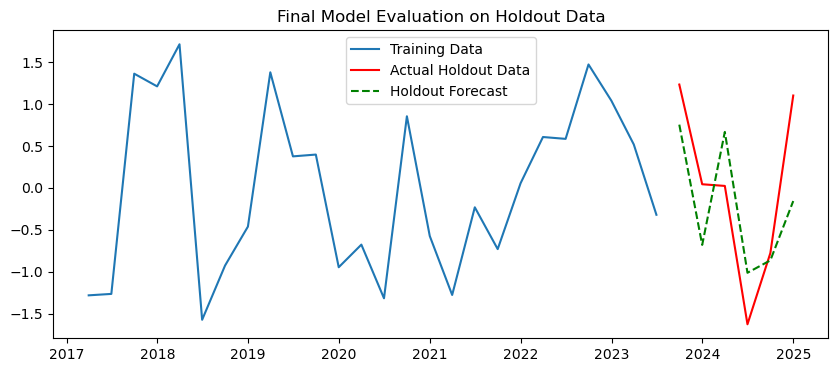

In [43]:

# Plot Predictions vs Actual
plt.figure(figsize=(10, 4))
plt.plot(train["ds"], train["y"].astype(float), label="Training Data")
plt.plot(val["ds"], val["y"].astype(float), label="Actual Holdout Data", color="red")
plt.plot(val["ds"], forecast_df["DLinear_12-hi-90"].values[:val["y"].shape[0]], label="Holdout Forecast", linestyle="dashed", color="green")
plt.title("Final Model Evaluation on Holdout Data")
plt.legend()
plt.show()

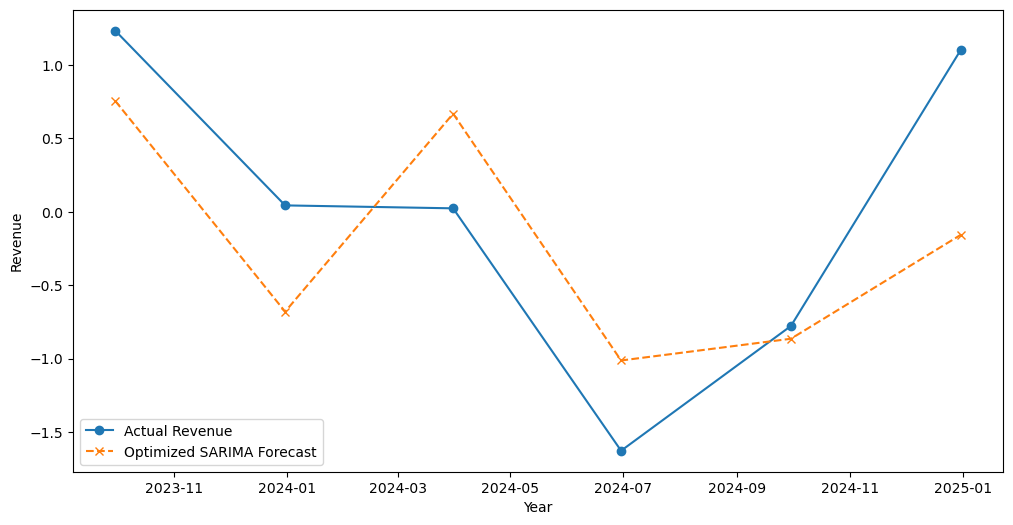

In [44]:
# Plot optimized forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(val["ds"], val["y"].astype(float), label="Actual Revenue", marker="o")
plt.plot(val["ds"], forecast_df["DLinear_12-hi-90"][:len(val["y"])], label="Optimized SARIMA Forecast", linestyle="dashed", marker="x")
plt.xlabel("Year")
plt.ylabel("Revenue")
#plt.title(f"Optimized SARIMA ({best_p}, {best_d}, {best_q}) x ({best_P}, {best_D}, {best_Q}, {S}) Forecast - SAP SE Revenue")
plt.legend()
plt.show()

In [52]:
def inverse_transform_series(scaler, data):
    """
    Inverse transforms the given data using the provided scaler and 
    returns a Pandas Series with the correct shape.
    
    Args:
        scaler: Fitted Scikit-learn MinMaxScaler or StandardScaler.
        data: NumPy array or Pandas Series/Column to be inverse transformed.
    
    Returns:
        pd.Series: Inverse transformed data as a Pandas Series.
    """
    # Ensure data is a NumPy array
    data = np.array(data)
    
    # Reshape if necessary (for scaler compatibility)
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    
    # Apply inverse transformation
    transformed_data = scaler.inverse_transform(data)
    
    # Flatten to 1D and convert to Pandas Series
    return pd.Series(transformed_data.flatten())

In [53]:
# y_pred = np.array(forecast_df["DLinear_12-hi-90"][:len(val["y"])].values).reshape(-1, 1)
# print(y_pred.shape)  # Ensure shape is (n_samples, 1)

# # Inverse transform
# y_pred = scaler.inverse_transform(y_pred)

# # Convert to Pandas Series (Flatten first)
# y_pred = pd.Series(y_pred.flatten())  # OR y_pred.ravel()


In [54]:
y_pred = inverse_transform_series(scaler, forecast_df["DLinear_12-hi-90"][:len(val["y"])].values)
y_true = inverse_transform_series(scaler, val["y"].values)
y_train = inverse_transform_series(scaler, train["y"].values)

print(y_pred.shape, y_true.shape, y_train.shape)  

(6,) (6,) (26,)


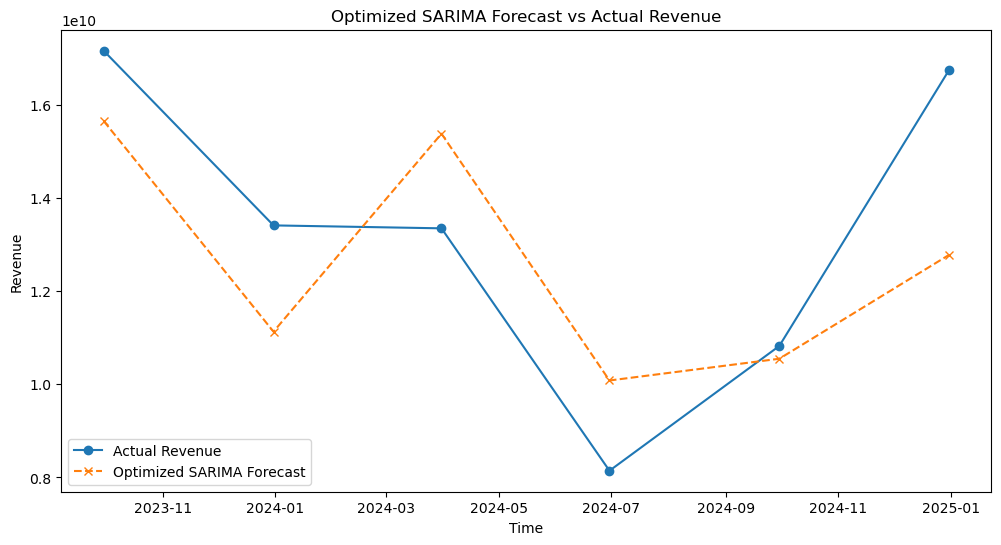

In [57]:
# Plot optimized forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(val["ds"], y_true, label="Actual Revenue", marker="o")
plt.plot(val["ds"], y_pred, label="Optimized SARIMA Forecast", linestyle="dashed", marker="x")
plt.xlabel("Time")
plt.ylabel("Revenue")
plt.title("Optimized SARIMA Forecast vs Actual Revenue")
plt.legend()
plt.show()


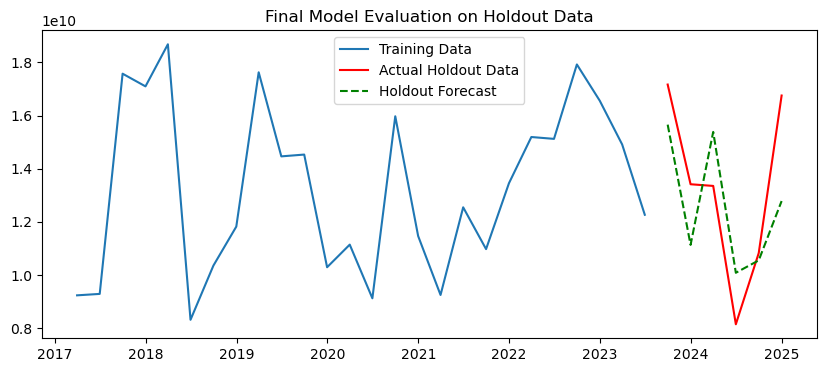

In [58]:
# Plot Predictions vs Actual

plt.figure(figsize=(10, 4))
plt.plot(train["ds"], y_train, label="Training Data")
plt.plot(val["ds"], y_true, label="Actual Holdout Data", color="red")
plt.plot(val["ds"], y_pred, label="Holdout Forecast", linestyle="dashed", color="green")
plt.title("Final Model Evaluation on Holdout Data")
plt.legend()
plt.show()

In [59]:
evaluate_model(y_true, y_pred, y_train, "Final Evaluation", start_time = time.time())

{'Model': 'Final Evaluation',
 'MSE': 5.20672609466167e+18,
 'MAE': 2001935958.5,
 'MAPE': 0.15181871524124305,
 'SMAPE': np.float64(15.448331071815339),
 'MASE': np.float64(0.6986862372709096),
 'R2 Score': 0.4760106644112536,
 'Time (s)': 0.002538442611694336}